In [1]:
import sys
import json
from IPython import display
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, precision_score, recall_score
from sklearn.pipeline import Pipeline

# parent directory to work with dev
sys.path.append("..")
import verifyml.model_card_toolkit as mctlib
from verifyml.model_card_toolkit import model_card_pb2, ModelCard
from verifyml.model_card_toolkit.utils.tally_form import tally_form_to_mc
from verifyml.model_tests.utils import plot_to_str
from verifyml.model_tests.FEAT import (
    SubgroupDisparity,
    MinMaxMetricThreshold,
    Perturbation,
    SHAPFeatureImportance,
    FeatureImportance,
    DataShift
)

## Read sample dataset and create ML model

In [2]:
# Loan repayment dataset
df = pd.read_csv("../data/loan_approval.csv")
df = df.fillna(method='backfill').dropna()
df['Loan_Status'] = df.Loan_Status.apply(lambda x: 1 if x =='N' else 0) # 1 -> Loan Rejected, 0 -> Loan Approved
x = df.drop(["Loan_Status","Loan_ID"] , axis=1)
y = df["Loan_Status"]

# Train-Test data Split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=89
)


## Build ML model with protected attributes as model features

# Apply one hot encoding to categorical columns (auto-detect object columns) and random forest model in the pipeline
estimator = Pipeline(steps=[('onehot', ce.OneHotEncoder(use_cat_names=True)),
                      ('classifier', RandomForestClassifier(n_estimators=12, max_depth=10, random_state = 900)
                      )])


# Fit, predict and compute performance metrics
estimator.fit(x_train, y_train)

output = x_test.copy() # x_test df with output columns, to be appended later
y_pred = estimator.predict(x_test)
y_probas = estimator.predict_proba(x_test)[::, 1]

precision_train = round(precision_score(y_train, estimator.predict(x_train)),3)
recall_train = round(recall_score(y_train, estimator.predict(x_train)), 3)
precision_test = round(precision_score(y_test, y_pred),3)
recall_test = round(recall_score(y_test, y_pred), 3)


# Add output columns to this dataframe, to be used as a input for feat tests
output["truth"] = y_test
output["prediction"] = y_pred
output["prediction_probas"] = y_probas


# Dataframe with categorical features encoded
x_train_encoded = estimator[0].transform(x_train)
x_test_encoded = estimator[0].transform(x_test)


# Get feature importance values
df_importance = pd.DataFrame(
    {"features": x_test_encoded.columns, "value": estimator[-1].feature_importances_}
)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


## Get confusion matrix and ROC curve on train/test set

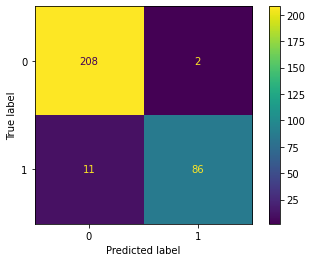

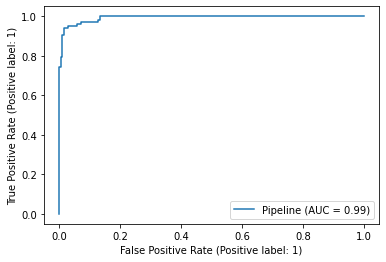

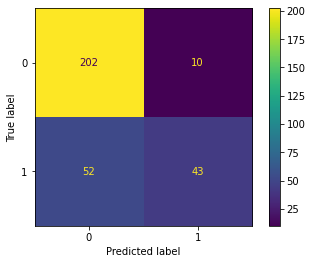

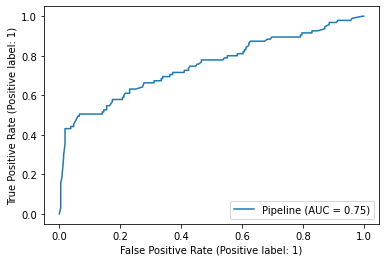

In [3]:
# Train set
ConfusionMatrixDisplay.from_estimator(estimator, x_train, y_train)
confusion_matrix_train = plot_to_str()

RocCurveDisplay.from_estimator(estimator, x_train, y_train)
roc_curve_train = plot_to_str()

# Test set
ConfusionMatrixDisplay.from_estimator(estimator, x_test, y_test)
confusion_matrix_test = plot_to_str()

RocCurveDisplay.from_estimator(estimator, x_test, y_test)
roc_curve_test = plot_to_str()

## Analysing model perfomance

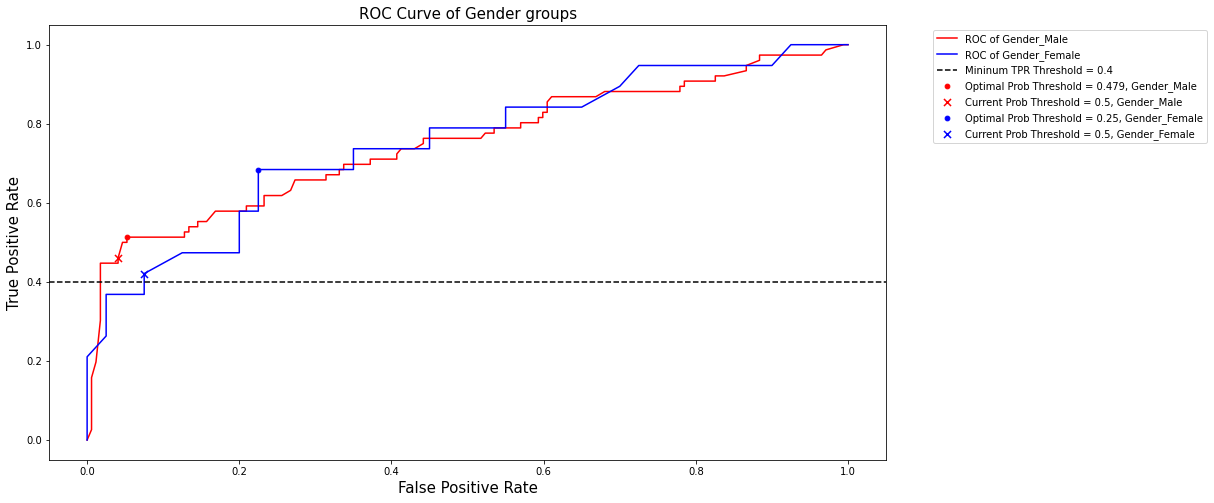

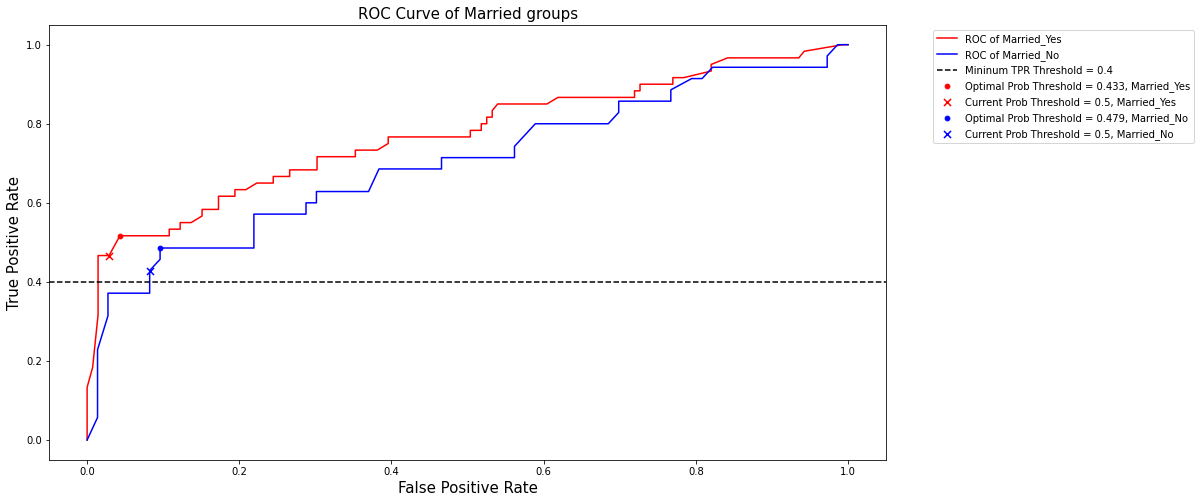

In [4]:
# ROC/Min Max Threshold Test

tpr_threshold_test_gender = MinMaxMetricThreshold(
    #test_name="",        # Default test name and description will be used accordingly if not specified
    #test_desc="",
    attr="Gender",
    metric="tpr",
    threshold=0.4,
    # proba_thresholds = {'Male':0.55,'Female':0.55,} # Custom probability threshold, default at 0.5
)
tpr_threshold_test_gender.run(df_test_with_output=output)
tpr_threshold_test_gender.plot()

tpr_threshold_test_married = MinMaxMetricThreshold(
    attr="Married",
    metric="tpr",
    threshold=0.4,
)
tpr_threshold_test_married.run(df_test_with_output=output)
tpr_threshold_test_married.plot()

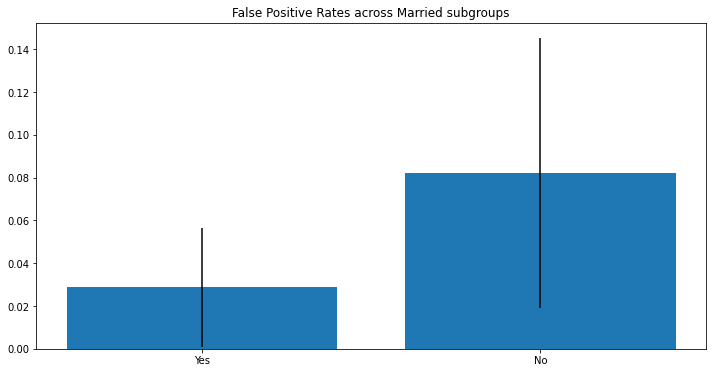

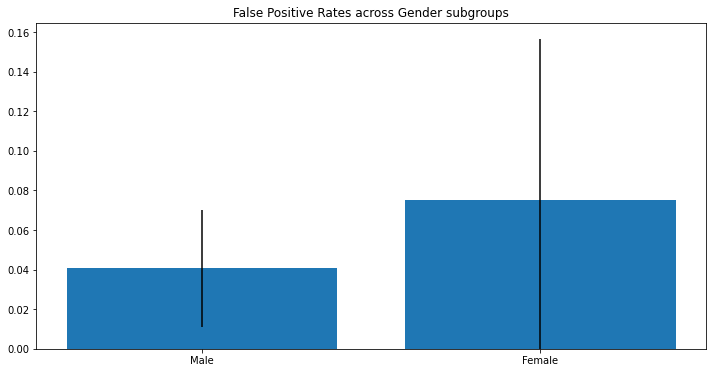

In [5]:
# Subgroup Disparity Test

sgd_test_married = SubgroupDisparity(
    attr='Married',
    metric='fpr',
    method='ratio',
    threshold=1.5,
)
sgd_test_married.run(output)
sgd_test_married.plot(alpha=0.05)     # default alpha argument shows 95% C.I bands

sgd_test_gender = SubgroupDisparity(
    attr='Gender',
    metric='fpr',
    method='ratio',
    threshold=1.5,
)
sgd_test_gender.run(output)
sgd_test_gender.plot(alpha=0.05)    # default alpha argument shows 95% C.I bands

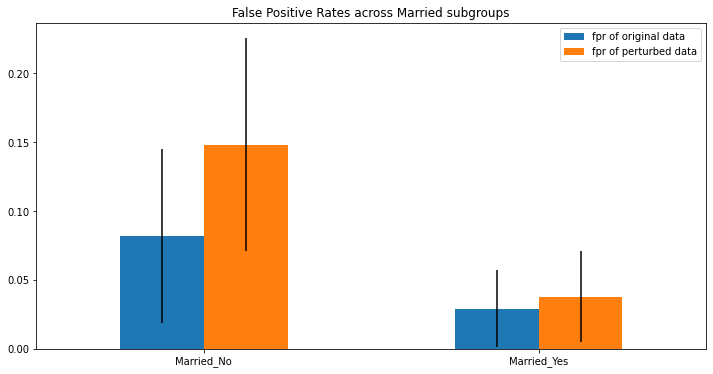

In [6]:
# Subgroup Perturbation Test

np.random.seed(123)
pmt = Perturbation(
    attr='Married',
    metric='fpr',
    method='ratio',
    threshold=1.5,
)

pmt.run(
    x_test=x_test,
    y_test=y_test,
    encoder=estimator[0],
    model=estimator[-1]
)

pmt.plot(alpha=0.05)   # default alpha argument shows 95% C.I bands

## Model explainability

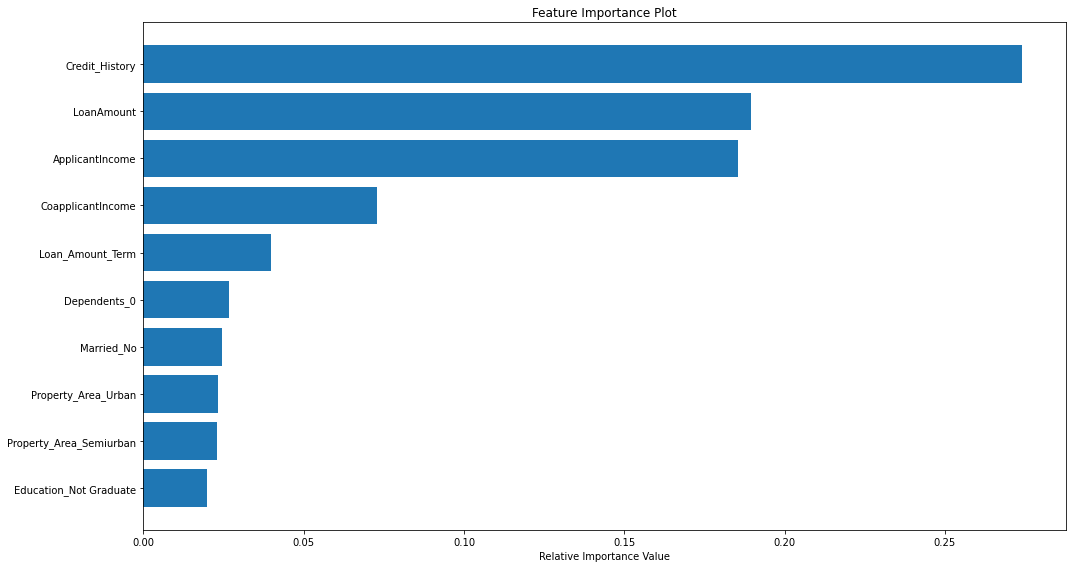

In [7]:
imp_test = FeatureImportance(
    attrs=['Gender','Married'],
    threshold=5
)

imp_test.run(df_importance)
imp_test.plot(df_importance, show_n=10)   # Show top 10 most important features

## Bootstrap model card from tally form and scaffold assets
We can add the quantitative analysis, explainability analysis and fairness analysis sections to a bootstrap model card for convenience. In this example, we use an existing model card which we created from the tally form response.

We will add a true positive rate threshold test to ensure a reasonable model perfomance and a false positive rate disparity test to ensure it does not discriminate across gender or marital status.

In [8]:
# Convert form response to model card protobuf
pb = tally_form_to_mc("sample-form-response-loan-approval.json")

# Initialize the mct and scaffold using the existing protobuf
mct = mctlib.ModelCardToolkit(output_dir = "model_card_output", file_name="loan_approval_example")
mc = mct.scaffold_assets(proto=pb)
mc.model_details.name = "Loan Approval Model, outcome probability threshold = 0.5"

## Convert test objects to a model-card-compatible format

In [9]:
# init model card test objects
mc_tpr_threshold_test_gender = mctlib.Test()
mc_tpr_threshold_test_married = mctlib.Test()
mc_sgd_test_married = mctlib.Test()
mc_sgd_test_gender = mctlib.Test()

# assign tests to them
mc_tpr_threshold_test_gender.read_model_test(tpr_threshold_test_gender)
mc_tpr_threshold_test_married.read_model_test(tpr_threshold_test_married)
mc_sgd_test_married.read_model_test(sgd_test_married)
mc_sgd_test_gender.read_model_test(sgd_test_gender)

In [10]:
# Add quantitative analysis

# Create 4 PerformanceMetric to store our results
mc.quantitative_analysis.performance_metrics = [mctlib.PerformanceMetric() for i in range(0, 5)]
mc.quantitative_analysis.performance_metrics[0].type = "Recall"
mc.quantitative_analysis.performance_metrics[0].value = str(recall_train)
mc.quantitative_analysis.performance_metrics[0].slice = "Training Set"

mc.quantitative_analysis.performance_metrics[1].type = "Precision"
mc.quantitative_analysis.performance_metrics[1].value = str(precision_train)
mc.quantitative_analysis.performance_metrics[1].slice = "Training Set"
mc.quantitative_analysis.performance_metrics[1].graphics.description = (
  'Confusion matrix and ROC Curve')
mc.quantitative_analysis.performance_metrics[1].graphics.collection = [
    mctlib.Graphic(image=confusion_matrix_train), mctlib.Graphic(image=roc_curve_train)
]

mc.quantitative_analysis.performance_metrics[2].type = "Recall"
mc.quantitative_analysis.performance_metrics[2].value = str(recall_test)
mc.quantitative_analysis.performance_metrics[2].slice = "Test Set"

mc.quantitative_analysis.performance_metrics[3].type = "Precision"
mc.quantitative_analysis.performance_metrics[3].value = str(precision_test)
mc.quantitative_analysis.performance_metrics[3].slice = "Test Set"
mc.quantitative_analysis.performance_metrics[3].graphics.description = (
  'Confusion matrix and ROC Curve')
mc.quantitative_analysis.performance_metrics[3].graphics.collection = [
    mctlib.Graphic(image=confusion_matrix_test), mctlib.Graphic(image=roc_curve_test)
]

mc.quantitative_analysis.performance_metrics[4].type = "True positive rate"
mc.quantitative_analysis.performance_metrics[4].tests = [mc_tpr_threshold_test_gender, mc_tpr_threshold_test_married]

In [11]:
# Add the fairness requirement for subgroup disparity
mc.fairness_analysis.fairness_reports[0].tests = [mc_sgd_test_married, mc_sgd_test_gender]

mct.update_model_card(mc)

## Model Card Display

In [12]:
# Export to html
html = mct.export_format(output_file="loan_approval_example.html")
display.display(display.HTML(html))

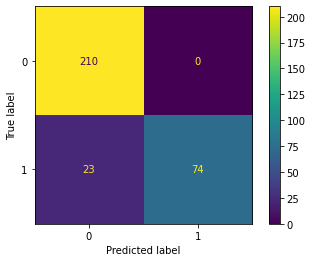

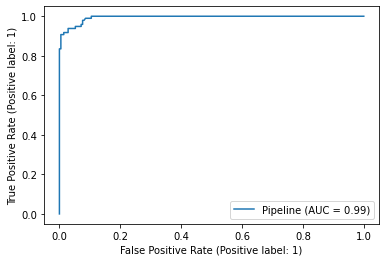

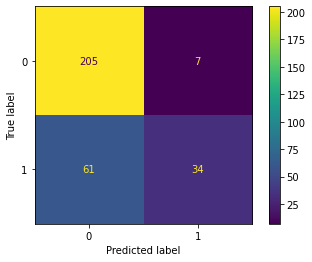

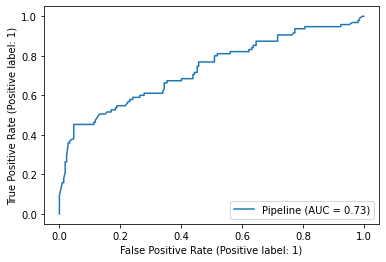

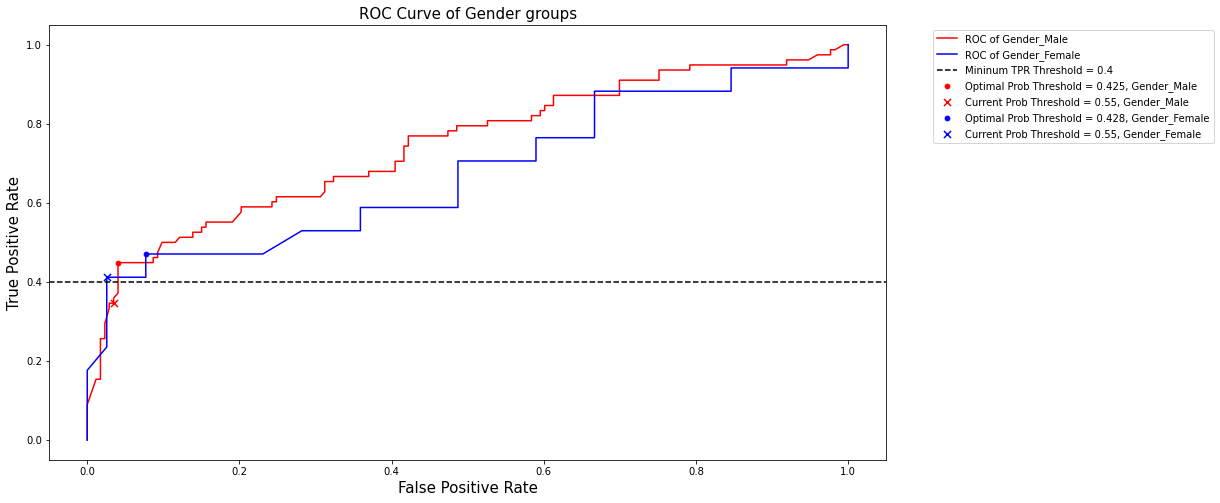

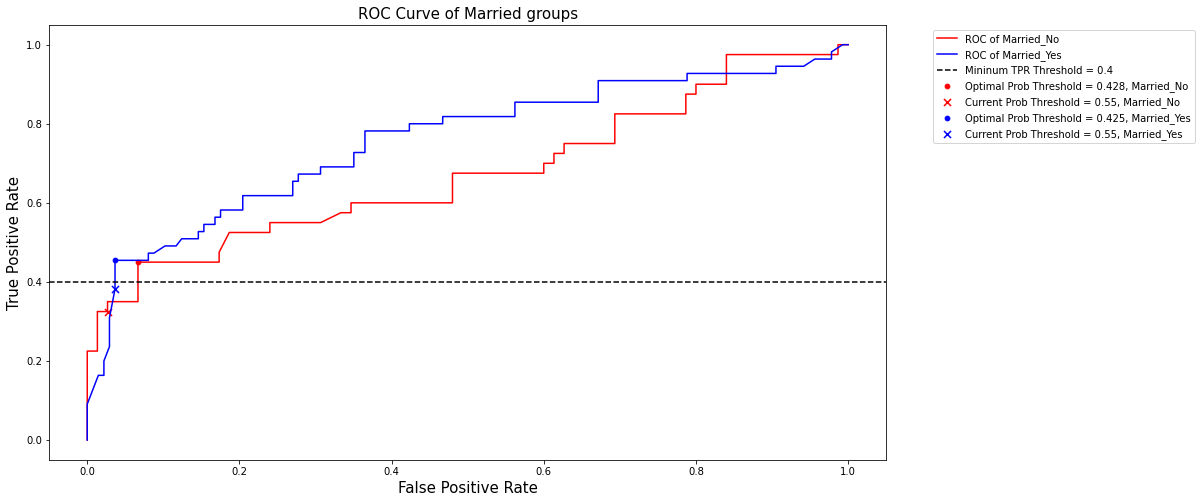

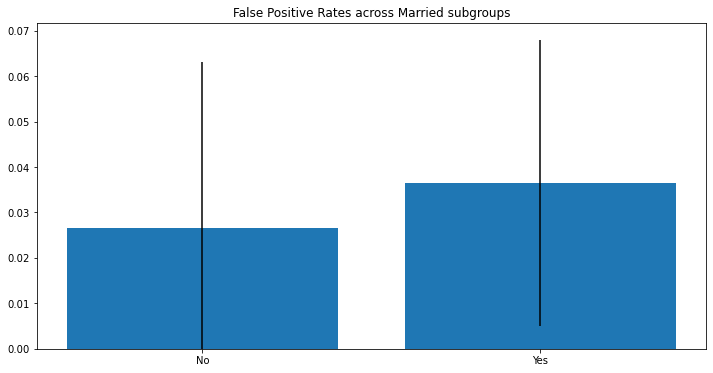

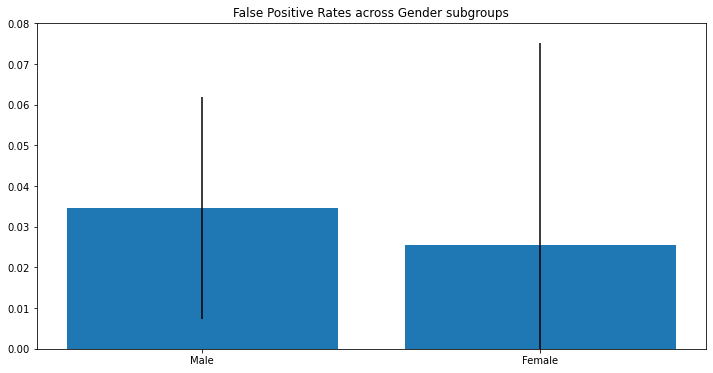

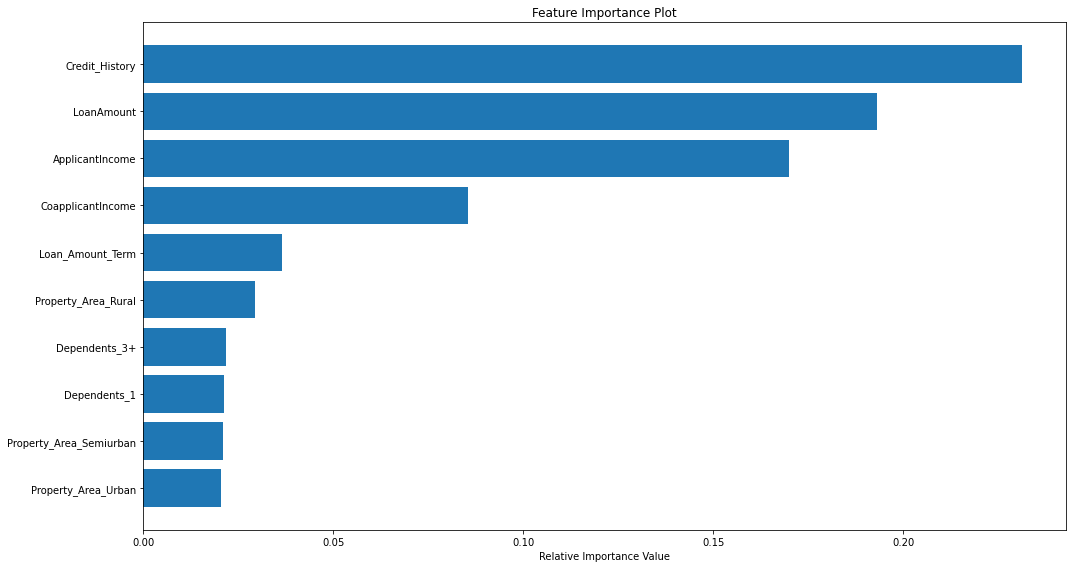

In [16]:
# Import model scorecard of second model (with outcome probability threshold = 0.55) from external python file
# Same steps taken as the first model, excluding irrelevant tests

# Model card to be compared with that of first model
from second_loan_model import mc2, mct2

In [17]:
# Export to html
html2 = mct2.export_format(output_file="loan_approval_example2.html")
display.display(display.HTML(html2))

## Comparision between 2 model cards

In [18]:
# Compare the score cards (on the same content) between model1 and model2
html_compare=mct.compare_model_cards(mc, mc2, export_path='model_card_output/model_cards/loan_approval_comparision.html')
display.display(display.HTML(html_compare))

,Married_fpr_max_ratio
0,2.856
,Gender_fpr_max_ratio
0,1.843
,Married_fpr_max_ratio
0,1.369
,Gender_fpr_max_ratio
0,1.353
